In [19]:
import pymongo
import math 
import re
import pandas as pd
import numpy as np
import pylab
from scipy import stats
from matplotlib import pyplot

from  qgrid import show_grid as show 
from datetime import datetime

testname="test1091118"
client = pymongo.MongoClient('172.16.45.8', 27017)
db = client.rapls
sensors= db["sensor"+testname]

In [8]:
def get_times(target,source=db["testcases"+testname]):
    x= list(db["testcases"+testname].find({'name':target}))[0]
    x['execution']=datetime.utcfromtimestamp(int(x['execution']))
    x['begin']=datetime.utcfromtimestamp(int(x['begin']))
    x['end']=datetime.utcfromtimestamp(int(x['end']))
    x['warmup']=datetime.utcfromtimestamp(int(x['warmup']))
    return x 

def calculate_power(targetname , source=db["sensor"+testname]):
    times=get_times(targetname)
    df = pd.DataFrame.from_dict(list(sensors.find({'timestamp' :{'$gte':times['begin'],'$lte':times['end']}})))
    result=df[df.target== targetname][["_id","rapl","timestamp"]]
    system=df[df.target== "system"] 
    result["rapl"]=result.apply(lambda row :math.ldexp(  system[system.timestamp==row['timestamp']].rapl.iloc[0]['0']['38']['RAPL_ENERGY_PKG'],-32), axis=1)
#     result['timestamp']= result.apply(lambda row :int(row['timestamp'].timestamp()),axis=1)
    return result

def calculate_energy(targetname) : 
    
    times=get_times(targetname)
    target=calculate_power(targetname)
    warmup = target[(target.timestamp >= times['warmup']) & (target.timestamp < times['execution']) ].loc[:,"rapl"].sum() 
    execution = target[(target.timestamp >= times['execution']) ].loc[:,"rapl"].sum() 
    return {'warmup':warmup,'execution': execution} 

def get_recap(target):
    energy=calculate_energy(target['name'])
    return {'name': target['name'] 
            ,'warmup time': (int(target['execution'])-int(target['warmup'])) 
            ,'warmup energy': energy['warmup'] 
            ,'execution time': (int(target['end'])-int(target['execution']) )
            ,'execution energy': energy['execution']}

In [4]:
def get_times(target,source=db["testcases"+testname]):
    x= list(db["testcases"+testname].find({'name':target}))[0]
    x['execution']=datetime.utcfromtimestamp(int(x['execution']))
    x['begin']=datetime.utcfromtimestamp(int(x['begin']))
    x['end']=datetime.utcfromtimestamp(int(x['end']))
    x['warmup']=datetime.utcfromtimestamp(int(x['warmup']))
    return x 

def calculate_power(times,source=sensors):
    df = pd.DataFrame.from_dict(list(sensors.find({'timestamp' :{'$gte':times['begin'],'$lte':times['end']}})))
#     print(times)
#     return 
    result=df[df.target== times['name']][["_id","rapl","timestamp"]]
    system=df[df.target== "system"] 
    result["rapl"]=result.apply(lambda row :math.ldexp(  system[system.timestamp==row['timestamp']].rapl.iloc[0]['0']['38']['RAPL_ENERGY_PKG'],-32), axis=1)
#     result['timestamp']= result.apply(lambda row :int(row['timestamp'].timestamp()),axis=1)
    return result

def calculate_energy(times) : 
    target=calculate_power(times)
    warmup = target[(target.timestamp >= times['warmup']) & (target.timestamp < times['execution']) ].loc[:,"rapl"].sum() 
    execution = target[(target.timestamp >= times['execution']) ].loc[:,"rapl"].sum() 
    return {'warmup':warmup,'execution': execution} 

def get_recap(target):
    times=get_times(target['name'])
    energy=calculate_energy(times)
    return {'name': target['name'] 
            ,'warmup time': (int(target['execution'])-int(target['warmup'])) 
            ,'warmup energy': energy['warmup'] 
            ,'execution time': (int(target['end'])-int(target['execution']) )
            ,'execution energy': energy['execution']}

In [30]:
regx = re.compile("sample2.*", re.IGNORECASE)
times=pd.DataFrame.from_dict(list(db["testcases"+testname].find({"name":regx})))
# data = pd.DataFrame(columns=['name','warmup time','warmup energy','execution time ','execution energy']) 
data=[]
times.apply(lambda row: data.append(get_recap(row)), axis=1)
    
data=pd.DataFrame.from_dict(data)
show(data)
# data

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fbb80b11a20>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fbb80c80a20>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fbb80aa4c50>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fbb80cc3ac8>}

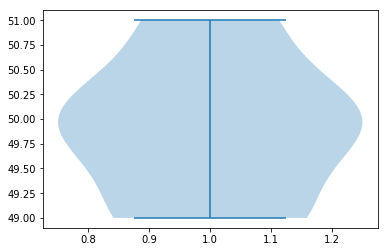

In [41]:
# data['execution time'].hist()
# data['execution time'].plot.kde()
# axes=stats.shapiro(data['execution time'])
# pyplot.violinplot(data['execution time'])